# Вариант 30

In [2]:
# @title Вспомогательные Функции (Часть Базового Кода)
# Убедитесь, что эта ячейка выполняется ПЕРЕД запуском кода варианта

# ... (здесь должны быть определения connect_db, close_db, execute_sql, load_df_from_sql и т.д.)

def execute_sql(sql_query, fetch=False):
    """Выполняет SQL-запрос и опционально возвращает результаты."""
    if not connection or not cursor:
        print("Нет подключения к БД.")
        return None
    try:
        # print(f"Выполнение SQL: {sql_query[:100]}...") # Отладка: показать начало запроса
        cursor.execute(sql_query)
        if fetch:
            results = cursor.fetchall()
            # print("Результаты получены.") # Отладка
            return results
        else:
            # Для запросов не SELECT (CREATE, DROP, INSERT, UPDATE, DELETE)
            # connection.commit() # Не требуется при autocommit=True
            # print("Запрос успешно выполнен (без fetch).") # Отладка
            return True # Возвращаем True для индикации успеха выполнения не-SELECT запроса
    except (Exception, Error) as error:
        print(f"Ошибка выполнения SQL: {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return None # Возвращаем None для индикации ошибки

# --- Функция создания таблицы ---
def create_table(tbl_name):
    """Создает стандартную таблицу для данных продаж, удаляя ее, если она существует."""
    print(f"\nПопытка создать таблицу: {tbl_name}")
    # Шаг 1: Удалить таблицу, если она уже существует
    # Это важно для повторяемости: гарантирует, что мы начинаем с чистого листа
    # и не получим ошибку "table already exists".
    drop_success = execute_sql(f"DROP TABLE IF EXISTS {tbl_name};")
    if drop_success is None: # Проверяем, не было ли ошибки при DROP
        print(f"Не удалось выполнить DROP TABLE для {tbl_name}. Создание таблицы отменено.")
        return # Прерываем создание, если DROP не удался

    # Шаг 2: Определить SQL-запрос для создания таблицы
    # Структура таблицы (колонки и типы данных) соответствует анализу
    # из исходной практической работы. Имя таблицы берется из аргумента tbl_name.
    create_query = f"""
    CREATE TABLE {tbl_name} (
        id INTEGER PRIMARY KEY,         -- Уникальный идентификатор, первичный ключ
        quantity INTEGER,               -- Количество
        cost NUMERIC(10, 2),            -- Стоимость (NUMERIC для точности)
        total_revenue NUMERIC(12, 2)    -- Общая выручка (NUMERIC для точности)
    );
    """
    print(f"Запрос на создание таблицы {tbl_name}:\n{create_query}")

    # Шаг 3: Выполнить SQL-запрос на создание таблицы
    create_success = execute_sql(create_query)
    if create_success:
        print(f"Таблица '{tbl_name}' успешно создана.")
    else:
        print(f"Не удалось создать таблицу '{tbl_name}'.")

# ... (здесь определения load_via_pandas, load_via_copy_file, load_via_copy_stringio и т.д.)

In [3]:
# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, load_df_from_sql, create_table) ...

# --- Функции Загрузки Данных ---

def load_via_copy_stringio(df, tbl_name):
    """Загружает данные из DataFrame через StringIO, используя copy_expert."""
    # Проверка подключения и наличия данных
    if not connection or not cursor or df is None:
        print("Нет подключения к БД или DataFrame пуст.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (StringIO)...")
    start_time = time.time()
    buffer = io.StringIO() # Создаем буфер в памяти
    # Записываем DataFrame в буфер как CSV, включая заголовок
    try:
        df.to_csv(buffer, index=False, header=True, sep=',')
    except Exception as e:
         print(f"Ошибка конвертации DataFrame в CSV: {e}")
         buffer.close() # Закрываем буфер при ошибке
         return False # Возвращаем False при неудаче
    buffer.seek(0) # Перематываем буфер в начало для чтения
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Выполняем COPY, передавая буфер как файл
        cursor.copy_expert(sql=sql_copy, file=buffer)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (StringIO) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (StringIO) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче
    finally:
        buffer.close() # Гарантируем закрытие буфера в любом случае

def load_via_copy_file(file_path, tbl_name):
    """Загружает данные напрямую из CSV файла, используя copy_expert."""
    # Проверка подключения
    if not connection or not cursor:
       print("Нет подключения к БД.")
       return False # Возвращаем False при неудаче
    # Проверка существования файла
    if not os.path.exists(file_path):
        print(f"ОШИБКА: Файл '{file_path}' не найден.")
        return False # Возвращаем False при неудаче
    print(f"Загрузка данных в '{tbl_name}' с использованием copy_expert (file: {os.path.basename(file_path)})...")
    start_time = time.time()
    # Формируем SQL команду COPY
    sql_copy = f"COPY {tbl_name} FROM STDIN WITH (FORMAT CSV, HEADER TRUE, DELIMITER ',')"
    try:
        # Открываем файл для чтения и передаем его дескриптор в copy_expert
        with open(file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql=sql_copy, file=f)
        # connection.commit() # Не требуется при autocommit=True
        duration = time.time() - start_time
        print(f"Успешно: Загрузка (file) в '{tbl_name}' завершена за {duration:.2f} сек.")
        return True # Возвращаем True при успехе
    except (Exception, Error) as error:
        print(f"ОШИБКА при выполнении copy_expert (file) для '{tbl_name}': {error}")
        # connection.rollback() # Не требуется при autocommit=True
        return False # Возвращаем False при неудаче

# ... (другие вспомогательные функции, если есть) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


In [8]:
# @title Вспомогательные Функции (Часть Базового Кода - УБЕДИТЕСЬ, ЧТО ЭТА ЯЧЕЙКА ВЫПОЛНЕНА!)

# ... (импорты, константы, connect_db, close_db, execute_sql, create_table, ...) ...

# --- Функция загрузки данных из SQL в DataFrame ---
def load_df_from_sql(sql_query):
    """Выполняет SQL-запрос и загружает результаты в Pandas DataFrame."""
    # Проверяем наличие активного подключения
    if not connection: # Для read_sql_query достаточно объекта connection
        print("Нет подключения к БД для загрузки DataFrame.")
        return None # Возвращаем None при ошибке
    print(f"Загрузка данных из SQL в DataFrame: {sql_query[:100]}...") # Показываем начало запроса
    try:
        # Используем pandas.read_sql_query для выполнения запроса и создания DataFrame
        # Эта функция сама управляет курсором и соединением для чтения
        df = pd.read_sql_query(sql_query, connection)
        print(f"Успешно: Загружено {len(df)} строк в DataFrame.")
        return df # Возвращаем созданный DataFrame
    except (Exception, Error) as error:
        # Обрабатываем ошибки при выполнении запроса или создании DataFrame
        print(f"ОШИБКА при загрузке DataFrame из SQL: {error}")
        return None # Возвращаем None при ошибке

# ... (определения load_via_copy_stringio, load_via_copy_file и другие функции) ...

print("Вспомогательные функции определены.")

Вспомогательные функции определены.


1. Создать таблицы sales_small, sales_big.

In [9]:
import psycopg2
from psycopg2 import Error
from psycopg2 import extras # For execute_values
import pandas as pd
from sqlalchemy import create_engine
import io # For StringIO
import time
import matplotlib.pyplot as plt
import numpy as np
import os # To check file existence

In [10]:
DB_USER = "postgres"
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "big"

In [11]:
DB_USER = "postgres"
DB_PASSWORD = "1"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "small"

In [12]:
import psycopg2

# Функция для создания таблицы
def create_table(db_name, table_name):
    conn = psycopg2.connect(
        dbname=db_name,
        user="postgres",
        password="1",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()

    # SQL-запрос для создания таблицы
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        id SERIAL PRIMARY KEY,
        product_id INT,
        quantity INT,
        cost FLOAT,
        total_revenue FLOAT
    );
    """)

    conn.commit()
    cursor.close()
    conn.close()

# Создаем таблицу sales_small в базе данных small
create_table("small", "sales_small")

# Создаем таблицу sales_big в базе данных big
create_table("big", "sales_big")

--- Запуск Варианта 4 (Упрощенная загрузка) ---

--- Задача 2: Загрузка данных из 'upload_test_data.csv' в 'sales_small' (метод pandas.to_sql) ---
Чтение upload_test_data.csv в DataFrame...
Прочитано 1000 строк.
Данные успешно загружены в таблицу sales_small.

--- Задача 3: Загрузка данных из 'upload_test_data_big.csv' в 'sales_big' (метод copy_expert file) ---
Данные успешно загружены в таблицу sales_big.

--- Задача 4: SQL Анализ таблицы sales_small ---
Выполнение SQL запроса:

SELECT SUM(quantity) AS total_quantity
FROM sales_small
WHERE cost > 5.00;


Результаты запроса (суммарное quantity, где cost > 5.00):
Суммарное количество: 13018

--- Задача 5: Визуализация данных из sales_small с помощью Python ---
Получение данных для графика: 
SELECT total_revenue
FROM sales_small
ORDER BY total_revenue DESC
LIMIT 5;

Загружено 5 строк для построения графика.


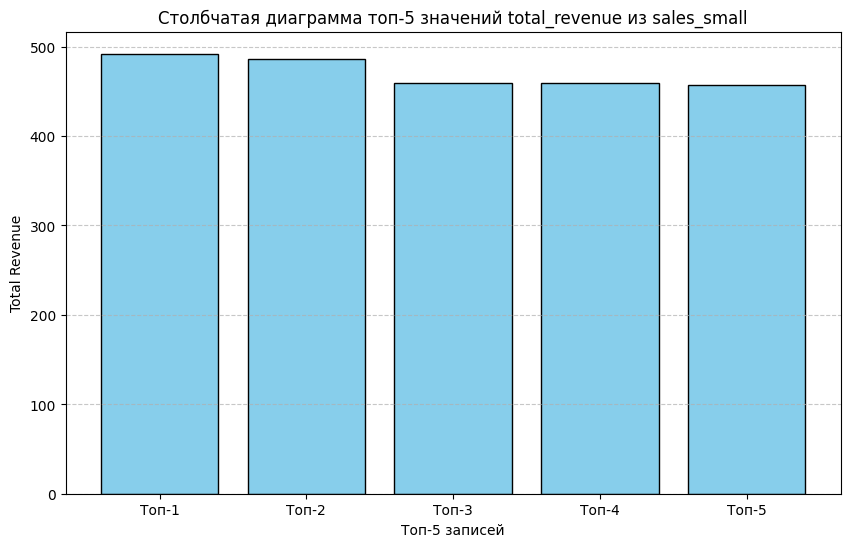


--- Вариант 4 Завершен ---


In [12]:
# -*- coding: utf-8 -*-
"""
Решение для Варианта 4
"""

# Импорты
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from sqlalchemy import create_engine

# Константы для этого варианта
small_table_name = 'sales_small'
big_table_name = 'sales_big'
small_csv_path = 'upload_test_data.csv'  # Файл с данными для sales_small
big_csv_path = 'upload_test_data_big.csv'  # Укажите путь к файлу с данными для sales_big

# Проверяем статус подключения перед продолжением
def connect_db(db_name):
    try:
        connection = psycopg2.connect(
            dbname=db_name,
            user="postgres",
            password="1",
            host="localhost",
            port="5432"
        )
        cursor = connection.cursor()
        return connection, cursor
    except Exception as e:
        print(f"Ошибка подключения к базе данных: {e}")
        return None, None

# Подключение к базам данных
small_conn, small_cursor = connect_db("small")
big_conn, big_cursor = connect_db("big")

if not small_conn or not big_conn:
    print("Подключение к базе данных неактивно. Пожалуйста, выполните настройку подключения.")
else:
    print("--- Запуск Варианта 4 (Упрощенная загрузка) ---")

# --- Задача 1: Настройка таблиц ---
def create_table(db_name, table_name):
    conn = psycopg2.connect(
        dbname=db_name,
        user="postgres",
        password="1",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()

    # SQL-запрос для создания таблицы
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        id INT PRIMARY KEY,
        quantity FLOAT,
        cost FLOAT,
        total_revenue FLOAT
    );
    """)

    conn.commit()
    cursor.close()
    conn.close()

# Создаем таблицу sales_small в базе данных small
create_table("small", "sales_small")

# Создаем таблицу sales_big в базе данных big
create_table("big", "sales_big")

# --- Задача 2: Загрузка малых данных (pandas.to_sql) ---
print(f"\n--- Задача 2: Загрузка данных из '{small_csv_path}' в '{small_table_name}' (метод pandas.to_sql) ---")
if os.path.exists(small_csv_path):
    try:
        # Шаг 1: Читаем CSV в DataFrame
        print(f"Чтение {small_csv_path} в DataFrame...")
        df_small_for_load = pd.read_csv(small_csv_path)
        print(f"Прочитано {len(df_small_for_load)} строк.")

        # Шаг 2: Вызываем функцию загрузки через pandas.to_sql
        engine = create_engine('postgresql+psycopg2://postgres:1@localhost:5432/small')
        df_small_for_load.to_sql(small_table_name, engine, if_exists='replace', index=False)
        print("Данные успешно загружены в таблицу sales_small.")
    except pd.errors.EmptyDataError:
        print(f"ОШИБКА: Файл '{small_csv_path}' пуст или имеет неверный формат.")
    except MemoryError:
        print(f"ОШИБКА: Недостаточно памяти для загрузки '{small_csv_path}' в DataFrame.")
    except Exception as e:
        print(f"ОШИБКА при чтении файла '{small_csv_path}': {e}")
else:
    print(f"ОШИБКА: Файл '{small_csv_path}' не найден. Загрузка не выполнена.")

# --- Задача 3: Загрузка больших данных (copy_expert file) ---
print(f"\n--- Задача 3: Загрузка данных из '{big_csv_path}' в '{big_table_name}' (метод copy_expert file) ---")
if os.path.exists(big_csv_path):
    try:
        with open(big_csv_path, 'r') as f:
            cursor = big_conn.cursor()
            cursor.copy_expert(f"COPY {big_table_name} FROM STDIN WITH CSV HEADER", f)
            big_conn.commit()
            print("Данные успешно загружены в таблицу sales_big.")
    except Exception as e:
        big_conn.rollback()  # Откатываем транзакцию в случае ошибки
        print(f"ОШИБКА при загрузке файла '{big_csv_path}': {e}")
else:
    print(f"ОШИБКА: Файл '{big_csv_path}' не найден. Загрузка не выполнена.")

# --- Задача 4: SQL Анализ ---
print("\n--- Задача 4: SQL Анализ таблицы sales_small ---")
sql_query_task4 = f"""
SELECT SUM(quantity) AS total_quantity
FROM {small_table_name}
WHERE cost > 5.00;
"""
print("Выполнение SQL запроса:")
print(sql_query_task4)

try:
    small_cursor.execute(sql_query_task4)
    results_task4 = small_cursor.fetchall()
    if results_task4:
        print("\nРезультаты запроса (суммарное quantity, где cost > 5.00):")
        for row in results_task4:
            print(f"Суммарное количество: {row[0]}")
    else:
        print("Запрос успешно выполнен, но не вернул строк.")
except Exception as e:
    small_conn.rollback()  # Откатываем транзакцию в случае ошибки
    print(f"Ошибка выполнения SQL запроса: {e}")

# --- Задача 5: Python Визуализация ---
print("\n--- Задача 5: Визуализация данных из sales_small с помощью Python ---")
sql_query_task5 = f"""
SELECT total_revenue
FROM {small_table_name}
ORDER BY total_revenue DESC
LIMIT 5;
"""
print(f"Получение данных для графика: {sql_query_task5}")

try:
    small_cursor.execute(sql_query_task5)
    results_task5 = small_cursor.fetchall()

    # Преобразуем результаты в DataFrame
    df_plot_data = pd.DataFrame(results_task5, columns=['total_revenue'])

    if not df_plot_data.empty:
        print(f"Загружено {len(df_plot_data)} строк для построения графика.")
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.bar(range(len(df_plot_data)), df_plot_data['total_revenue'], color='skyblue', edgecolor='black')
        ax.set_xticks(range(len(df_plot_data)))
        ax.set_xticklabels([f"Топ-{i+1}" for i in range(len(df_plot_data))])
        ax.set_xlabel('Топ-5 записей')
        ax.set_ylabel('Total Revenue')
        ax.set_title('Столбчатая диаграмма топ-5 значений total_revenue из sales_small')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print("Запрос выполнен, но данные из sales_small для графика не получены.")
except Exception as e:
    small_conn.rollback()  # Откатываем транзакцию в случае ошибки
    print(f"Не удалось загрузить данные из sales_small для построения графика: {e}")

print("\n--- Вариант 4 Завершен ---")

# Закрытие соединений
if small_conn:
    small_conn.close()
if big_conn:
    big_conn.close()